In [319]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
import random
from PIL import Image
from torchvision import transforms
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF

from src.data import get_single_cifar10_dataloader as get_cifar10_dataloader

In [320]:
directory_real= "CIFAR10_class4_training"
directory_augmented = "CIFAR10_class4_augmented"
directory_vanilla_gan = "CIFAR10_class4_vanilla_gan_generated"
directory_custom_gan = "CIFAR10_class4_customgan_generated"

In [321]:
def load_images_as_tensors(directory, sample_size=500):
    # Check if the directory exists
    if not os.path.exists(directory):
        raise ValueError("The specified directory does not exist.")

    # List all image files in the directory
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure there are enough images
    if len(image_files) < sample_size:
        raise ValueError(f"The directory contains less than {sample_size} images.")

    # Randomly select sample_size images
    selected_images = random.sample(image_files, sample_size)

    # Define a transform to convert images to tensors
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize images to a fixed size (modify if needed)
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
 
    # Load images, apply transforms and stack them into a single tensor
    tensors = []
    for image_file in selected_images:
        img = Image.open(os.path.join(directory, image_file)).convert('RGB')
        tensor = transform(img)
        tensors.append(tensor)

    # Stack all image tensors into a single tensor
    batch_tensor = torch.stack(tensors)

    return batch_tensor


In [322]:
real_image_tensors = load_images_as_tensors(directory_real)
real_image_tensors.shape

torch.Size([500, 3, 32, 32])

In [323]:
augmented_image_tensors = load_images_as_tensors(directory_augmented)
augmented_image_tensors.shape

torch.Size([500, 3, 32, 32])

In [324]:
vanillagan_image_tensors = load_images_as_tensors(directory_vanilla_gan)
vanillagan_image_tensors.shape

torch.Size([500, 3, 32, 32])

In [325]:
customgan_image_tensors = load_images_as_tensors(directory_custom_gan)
customgan_image_tensors.shape

torch.Size([500, 3, 32, 32])

In [326]:
def show_imgs(imgs):
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.transpose((img+1)/2.0, (1, 2, 0)))
        plt.axis('off')
    plt.show()

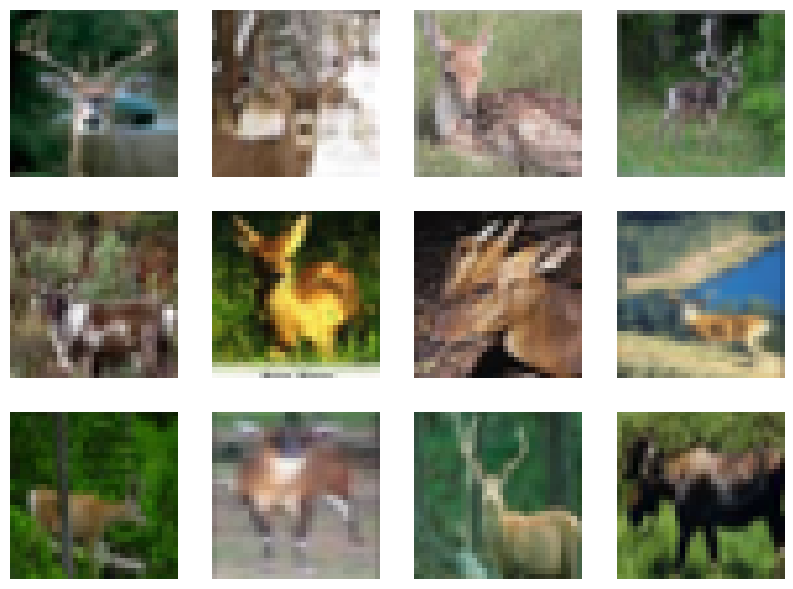

In [327]:
#show only first 10 images
show_imgs(real_image_tensors[:12])

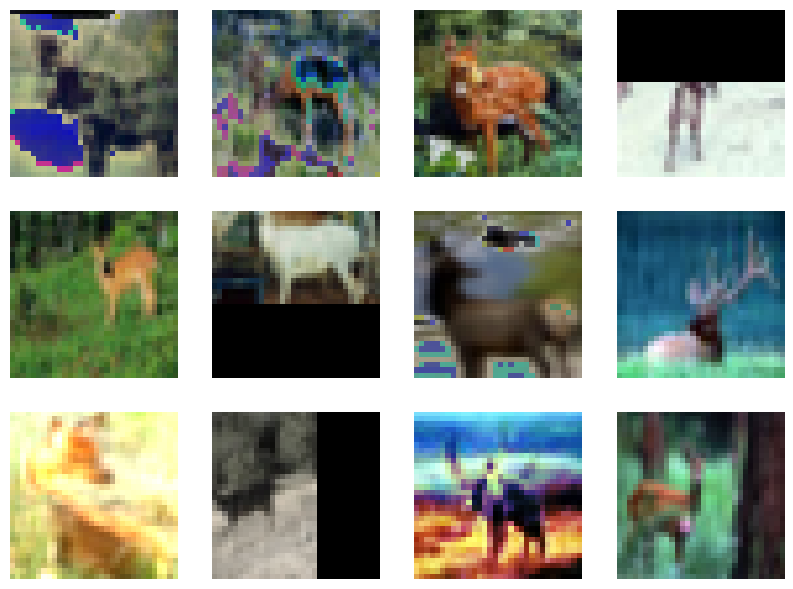

In [328]:
show_imgs(augmented_image_tensors[:12])

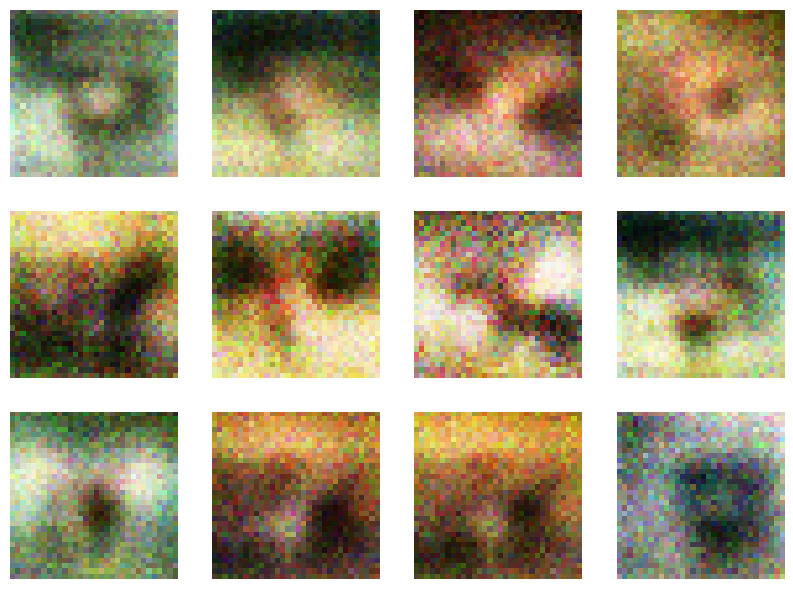

In [329]:
show_imgs(vanillagan_image_tensors[:12])

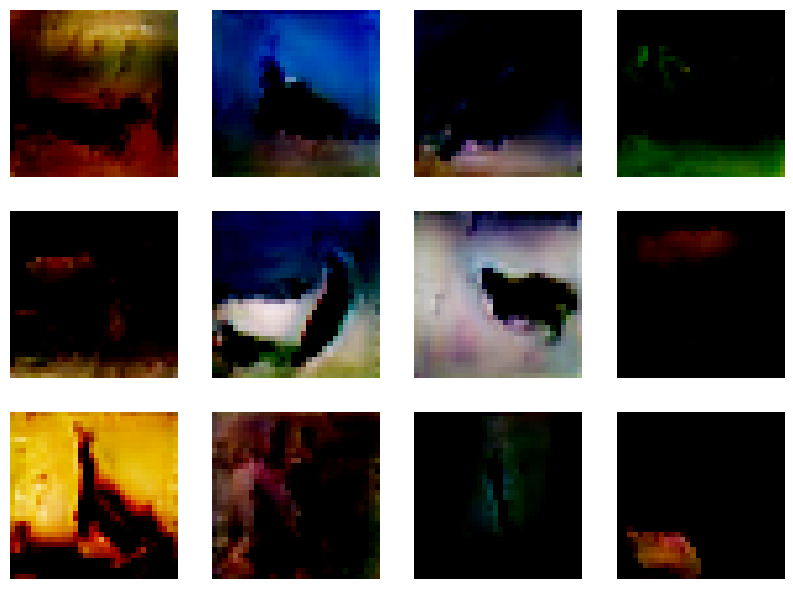

In [330]:
show_imgs(customgan_image_tensors[:12])

In [331]:
high_std_array = np.random.normal(loc=0.0, scale=10.0, size=(100, 3, 32, 32))
low_std_array = np.random.normal(loc=0.0, scale=0.1, size=(100, 3, 32, 32))

In [332]:
# Flattening the arrays
high_std_flattened = high_std_array.reshape(high_std_array.shape[0], -1)
low_std_flattened = low_std_array.reshape(low_std_array.shape[0], -1)
real_imgs_flattened = real_image_tensors.reshape(real_image_tensors.shape[0], -1)
augmented_imgs_flattened = augmented_image_tensors.reshape(augmented_image_tensors.shape[0], -1)
vanillagan_imgs_flattened = vanillagan_image_tensors.reshape(vanillagan_image_tensors.shape[0], -1)
customgan_imgs_flattened = customgan_image_tensors.reshape(customgan_image_tensors.shape[0], -1)


In [333]:
def calculate_diversity(input_array: np.ndarray) -> float:
    # If input array is not tensor, convert it to tensor
    if not isinstance(input_array, torch.Tensor):
        input_tensor = torch.tensor(input_array)
    else:
        input_tensor = input_array
    
    # Ensure the tensor is in the right shape (n_samples, n_features)
    if input_tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (n_samples, n_features)")
    
    # Calculate pairwise distances
    n_samples = input_tensor.size(0)
    distances = torch.norm(input_tensor[:, None] - input_tensor, dim=2, p=2)
    
    # Mask to exclude self-distances (diagonal) from the average
    mask = ~torch.eye(n_samples, dtype=bool)
    
    # Calculate the average distance, excluding self-distances
    avg_distance = torch.mean(distances[mask]).item()  # Convert to Python float
    
    return avg_distance

In [334]:
def calculate_quality(input_tensor) -> float:
    return 0.0

## Testing the Code

### Image Diversity

### Simple Approach

This should return a high value since the noise array `high_std_array` has a high standard deviation

In [335]:
calculate_diversity(high_std_flattened)

783.5978154131908

This should return a **low** value since the noise array `low_std_array` has a low standard deviation

In [336]:
calculate_diversity(low_std_flattened)

7.845713592789573

This should return a value roughly between a tensor with very low standard deviation and very high standard deviation
because artificially generated noise with very high std should have a higher variety than real images but in comparison
to `low_std_array` it should be higher since the deers have _some_ variance.

In [337]:
calculate_diversity(real_imgs_flattened)

32.132545471191406

In [338]:
calculate_diversity(augmented_imgs_flattened)

41.28621292114258

In [339]:
calculate_diversity(vanillagan_imgs_flattened)

33.60072326660156

In [340]:
calculate_diversity(customgan_imgs_flattened)

29.643003463745117

### t-SNE


### Image Quality

### FID

This should return a **high** value since the image quality of **real** images is high (basically "as good as it gets")

In [341]:
calculate_quality(real_image_tensors)

0.0

This should return a **low** value since the image quality of noise poor (there is basically no real image features)

In [342]:
calculate_quality(low_std_array)

0.0